<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/pytorch_nf_freia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Freia - Linear Transforms

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    !pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb corner nflows
    !pip install git+https://github.com/VLL-HD/FrEIA.git

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as dist

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import seed_everything

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import ml_collections
import wandb

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

Using device: cuda


## Logging

In [34]:
cfg = ml_collections.ConfigDict()

# Logger
cfg.wandb_project = "gf2_0"
cfg.wandb_entity = "ipl_uv"
cfg.batch_size = 256
cfg.num_workers = 8
cfg.seed = 123

# Data
cfg.n_train = 10_000
cfg.n_valid = 1_000
cfg.n_test = 2_000
cfg.noise = 0.05

# Model
cfg.n_layers = 8
cfg.n_features = 2
cfg.n_reflections = 2
cfg.coupling = "glow"

# Training
cfg.num_epochs = 100
cfg.learning_rate = 1e-2
cfg.n_total_steps = cfg.num_epochs * cfg.n_train
cfg.loss_fn = "inn"

In [35]:
seed_everything(cfg.seed)

Global seed set to 123


123

In [36]:
# wandb_logger = WandbLogger(project=cfg.wandb_project, entity=cfg.wandb_entity)
# wandb_logger.experiment.config.update(cfg)


## Data

In [37]:
from sklearn.datasets import make_moons

data, label = make_moons(n_samples=cfg.n_train, noise=cfg.noise)

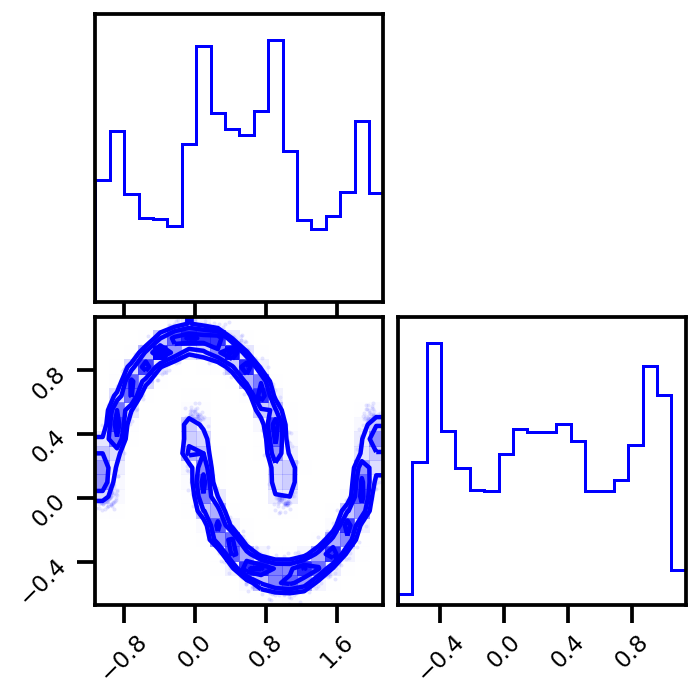

In [38]:
fig = corner.corner(data, hist_factor=2, color="blue")

#### DataLoader

In [39]:

data_train, label = make_moons(n_samples=cfg.n_train, noise=cfg.noise, random_state=123)
data_valid, label = make_moons(n_samples=cfg.n_valid, noise=cfg.noise, random_state=42)
X_train = torch.FloatTensor(data_train)
X_valid = torch.FloatTensor(data_valid)

# make into dataset
train_ds = TensorDataset(X_train)
valid_ds = TensorDataset(X_valid)

# make dataloader
shuffle = True

train_dl = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=shuffle, num_workers=cfg.num_workers)
valid_dl = DataLoader(valid_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

In [40]:
from src.data.utils import tensor2numpy, numpy2tensor

## Model

### Lightning Module

In [41]:
from src.experiments.plane.train import PlaneFlow

In [42]:
from src.models.layers.linear import LinearLayer


### Standard RVP

In [54]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from src.models.layers.coupling import get_coupling_layer
from src.models.layers.linear import create_linear_transform
from src.models.layers.linear import LinearLayer


# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
hidden_dim = 512

def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_dim), nn.ReLU(),
                         nn.Linear(hidden_dim,  dims_out))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(cfg.n_features)

for k in range(cfg.n_layers):
    
    # coupling transform (GLOW)
    coupling_transform = get_coupling_layer(coupling="affine")
    
    # create coupling transform
    inn.append(
        coupling_transform, 
        subnet_constructor=subnet_fc,
        
    )
    
#     # linear transform (orthogonal)
#     inn.append(Fm.HouseholderPerm, n_reflections=cfg.n_reflections)
    # linear transformation (NFlows Layers)
    inn.append(
        LinearLayer, 
        transform="svd",
        num_householder=cfg.n_reflections,
        with_permutations=False
    )



base_dist = dist.Normal(0.0, 1.0)

#### Initial Transformation

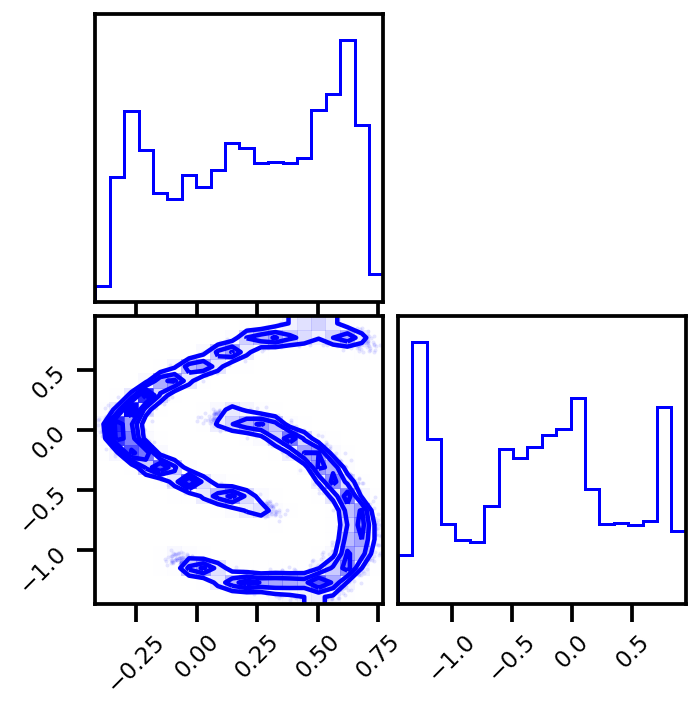

In [55]:
x = torch.Tensor(data)
z, log_jac_det = inn(x)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="blue")

## Training

In [56]:
cfg.lr_scheduler = "cosine_annealing"
cfg.weight_decay = 1e-4
cfg.gamma = 0.99
cfg.learning_rate = 1e-2
cfg.n_total_steps = cfg.num_epochs * cfg.n_train
cfg.n_total_dims = 2

In [57]:
learn = PlaneFlow(inn, cfg)
trainer = pl.Trainer(
    # epochs
    min_epochs=5, 
    max_epochs=100, #cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=100, 
    # device
    gpus="1",
    # gradient norm
    gradient_clip_val=1.0, 
    gradient_clip_algorithm='norm', 
#     logger=wandb_logger
)
trainer.fit(learn, train_dataloader=train_dl, val_dataloaders=valid_dl)

/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/utilities/device_parser.py:135: LightningDeprecationWarning: Parsing of the Trainer argument gpus='1' (string) will change in the future. In the current version of Lightning, this will select CUDA device with index 1, but from v1.5 it will select gpus [0] (same as gpus=1 (int)).
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:530: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 16.5 K
-----------------------------

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 123
/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

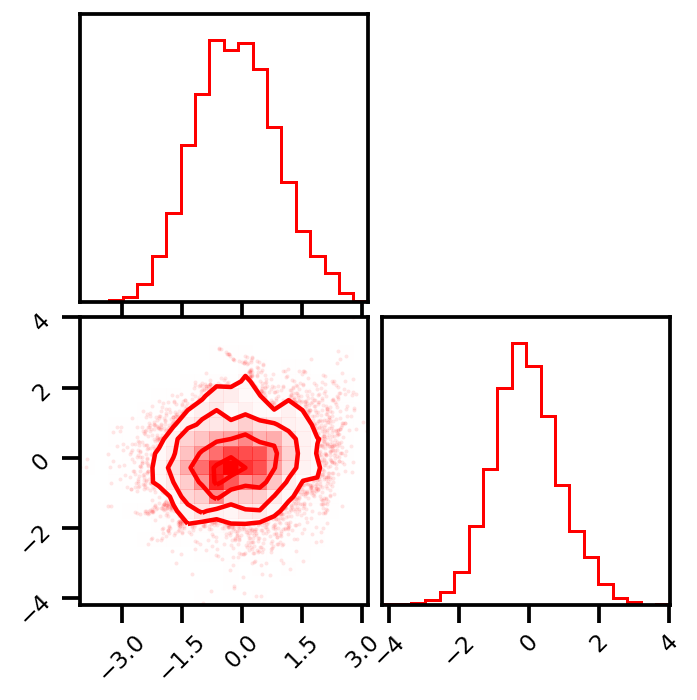

In [58]:
z, log_jac_det = learn.model(X_train)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="red")
# wandb_logger.experiment.log({"latent_trained": wandb.Image(fig)})

#### Inverse Transform

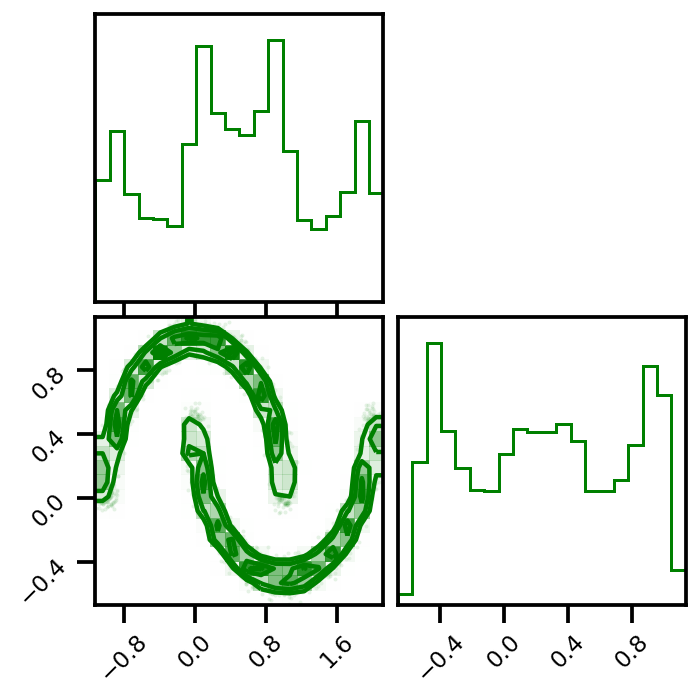

In [59]:
x_ori, _ = learn.model(z, rev=True)

fig = corner.corner(x_ori.detach().numpy(), hist_factor=2, color="green")
# wandb_logger.experiment.log({"latent_trained_inv": wandb.Image(fig)})

#### Density Estimation

In [60]:
from src.viz.bivariate import generate_2d_grid

# Read data
X_plot, _ = make_moons(n_samples=100_000, shuffle=True, noise=0.05, random_state=123 + 2)

# # sampled data
data_plot, label = make_moons(n_samples=100, noise=0.05)
xyinput = generate_2d_grid(data_plot, 500, buffer=0.1)

In [61]:
z, log_jac_det = learn.model(torch.Tensor(xyinput))

X_log_prob = base_dist.log_prob(z).sum(1) + log_jac_det
X_log_prob = X_log_prob.detach().numpy()

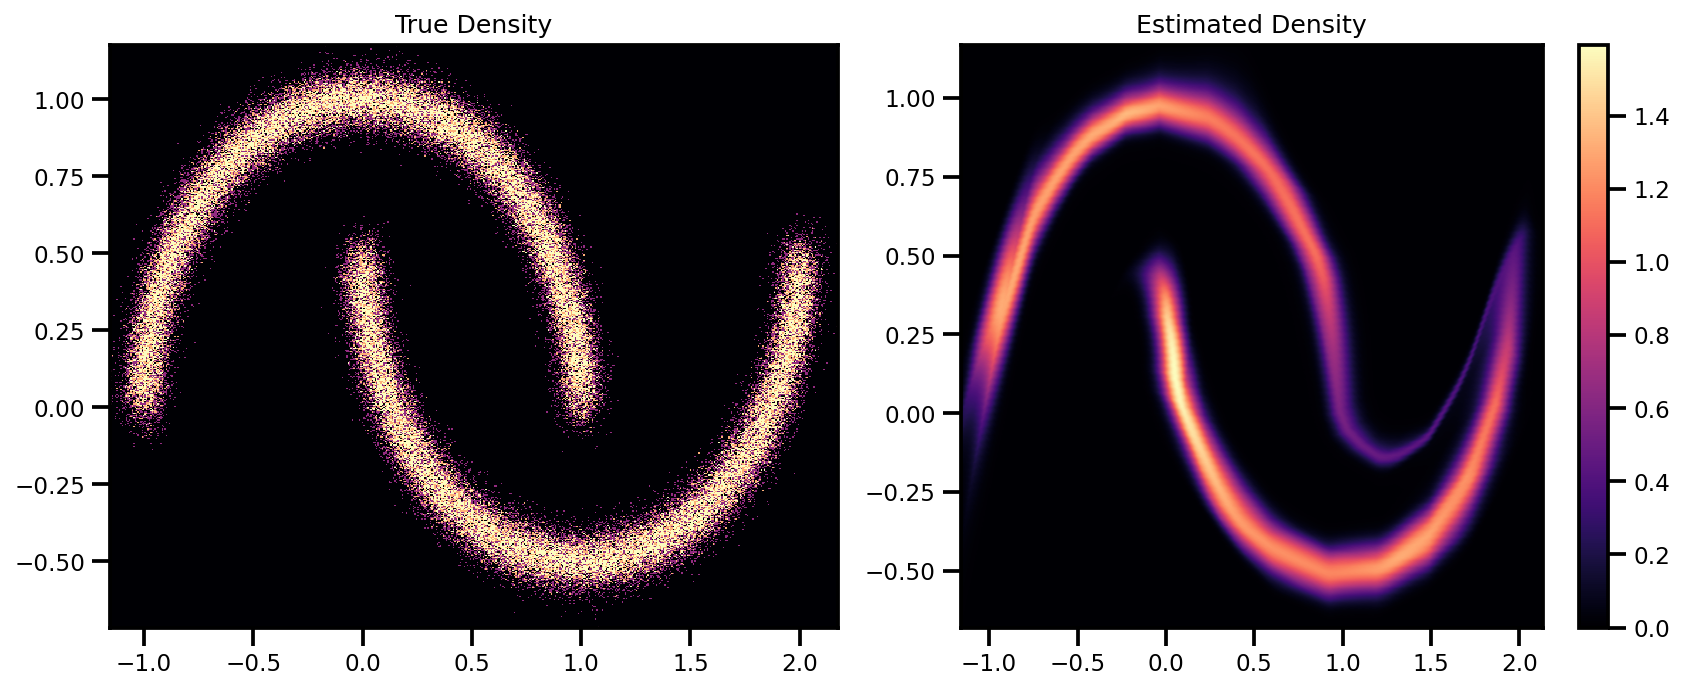

In [62]:
from matplotlib import cm

# # Original Density
# n_samples = 1_000_000
# n_features = 2
# X_plot = load_data(n_samples, 42)
# X_plot = StandardScaler().fit_transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = np.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"
# cmap = "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)


h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, #vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()
# wandb_logger.experiment.log({"density": wandb.Image(fig)})

#### Sampling

In [63]:
%%time

# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 100_000
z = torch.randn(n_samples, cfg.n_features)
samples, _ = learn.model(z, rev=True)



CPU times: user 12.8 s, sys: 1.64 s, total: 14.4 s
Wall time: 1.58 s


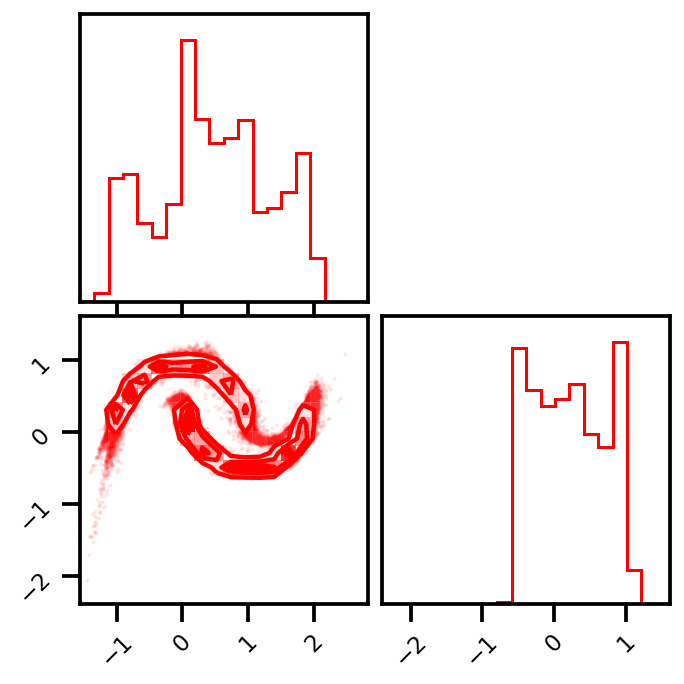

In [64]:
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")
# wandb_logger.experiment.log({"sampling_trained": wandb.Image(fig)})